# Case Study: Hidden Markov Model

Use moving average cross-over strategy and see if we can improve upon the returns by selecting only favourable HMM states which are generated as out-of-sample data for maximum caution.


## Imports

In [4]:
import pandas as pd
import numpy as np
import datetime
import yfinance as yf
import backtrader as bt
from pyhhmm.gaussian import GaussianHMM
from pandas_datareader.data import DataReader

import matplotlib.pyplot as plt

## Data preprocessing

In [5]:
stocks = []
cerebro = bt.Cerebro()

# input start and end date from user
try:
    start_dt = datetime.datetime.strptime( str(input("Start Date (in YYYYMMDD format):")), '%Y%m%d')
    end_dt = datetime.datetime.strptime( str(input("End Date (in YYYYMMDD format):")) , '%Y%m%d')
except (ValueError, TypeError):
    raise Exception("Wrong format. Try again.")

In [6]:
df_yf = yf.download("SPY",start_dt,end_dt)

[*********************100%***********************]  1 of 1 completed


In [8]:
data = df_yf[["Open", "High", "Low", "Adj Close"]]
#data

,Open,High,Low,Adj Close
Date,,,,
2020-01-02,323.540009,324.890015,322.529999,309.694855
2020-01-03,321.160004,323.640015,321.100006,307.349762
2020-01-06,320.489990,323.730011,320.359985,308.522369
2020-01-07,323.019989,323.540009,322.239990,307.654877
2020-01-08,322.940002,325.779999,322.670013,309.294556
...,...,...,...,...
2022-12-22,383.049988,386.209991,374.769989,380.720001
2022-12-23,379.649994,383.059998,378.029999,382.910004
2022-12-27,382.790009,383.149994,379.649994,381.399994


In [9]:
# Add Returns and Range
df = data.copy()
df["Returns"] = (df["Adj Close"] / df["Adj Close"].shift(1)) - 1
df["Range"] = (df["High"] / df["Low"]) - 1
df.dropna(inplace=True)
print("Length: ", len(df))
df.head()

Length:  754


,Open,High,Low,Adj Close,Returns,Range
Date,,,,,,
2020-01-03,321.160004,323.640015,321.100006,307.349762,-0.007572,0.007910
2020-01-06,320.489990,323.730011,320.359985,308.522369,0.003815,0.010519
2020-01-07,323.019989,323.540009,322.239990,307.654877,-0.002812,0.004034
2020-01-08,322.940002,325.779999,322.670013,309.294556,0.005330,0.009638
2020-01-09,326.160004,326.730011,325.519989,311.391724,0.006780,0.003717


In [10]:
# Add Moving Average
df["MA_12"] = df["Adj Close"].rolling(window=12).mean()
df["MA_21"] = df["Adj Close"].rolling(window=21).mean()

In [11]:
# Structure Data
X_train = df[["Returns", "Range"]].iloc[:500]
X_test = df[["Returns", "Range"]].iloc[500:]
save_df = df.iloc[500:]

print("Train Length: ", len(X_train))
print("Test Length: ", len(X_test))
print("X_train From: ", X_train.head(1).index.item())
print("X_train To: ", X_train.tail(1).index.item())
print("X_test From: ", X_test.head(1).index.item())
print("X_test To: ", X_test.tail(1).index.item())

Train Length:  500
Test Length:  254
X_train From:  2020-01-03 00:00:00
X_train To:  2021-12-27 00:00:00
X_test From:  2021-12-28 00:00:00
X_test To:  2022-12-29 00:00:00


### Train HMM

In [98]:
# Train HMM
model = GaussianHMM(n_states=4, covariance_type='full', n_emissions=2)
model.train([np.array(X_train.values)])
model.predict([X_train.values])[0][:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [99]:
# Make Prediction on Test Data
df_main = save_df.copy()
df_main.drop(columns=["High", "Low"], inplace=True)

hmm_results = model.predict([X_test.values])[0]
df_main["HMM"] = hmm_results
df_main.head()

,Open,Adj Close,Returns,Range,MA_12,MA_21,HMM
Date,,,,,,,
2021-12-28,477.720001,469.257050,-0.000817,0.005777,459.205635,455.926056,0
2021-12-29,476.980011,469.857391,0.001279,0.005547,459.893483,456.605816,0
2021-12-30,477.929993,468.558441,-0.002765,0.007001,460.813838,457.645842,0
2021-12-31,475.640015,467.377563,-0.002520,0.004614,461.898099,458.865913,0
2022-01-03,476.299988,470.083649,0.005790,0.008441,462.616241,459.892652,0


In [100]:
hidden_states = model.predict([X_train.values])[0]

In [104]:
# Structure the prices for plotting
i = 0
labels_0 = []
labels_1 = []
labels_2 = []
labels_3 = []
prices = df["Adj Close"][:500].values.astype(float)
print("Correct number of rows: ", len(prices) == len(hidden_states))
for s in hidden_states:
    if s == 0:
        labels_0.append(prices[i])
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 1:
        labels_0.append(float('nan'))
        labels_1.append(prices[i])
        labels_2.append(float('nan'))
        labels_3.append(float('nan'))
    if s == 2:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(prices[i])
    if s == 3:
        labels_0.append(float('nan'))
        labels_1.append(float('nan'))
        labels_2.append(float('nan'))
        labels_3.append(prices[i])    
    i += 1

Correct number of rows:  True


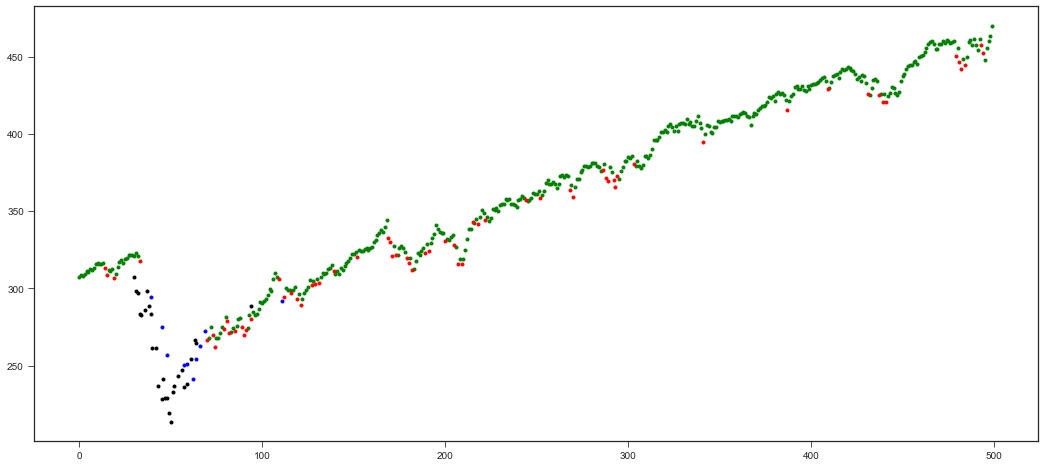

In [105]:
# Plot Chart to visualize HMM status
fig = plt.figure(figsize= (18, 8))
plt.plot(labels_0, '.', color="green")
plt.plot(labels_1, '.', color="blue")
plt.plot(labels_2, '.', color="red")
plt.plot(labels_3, '.', color="black")
plt.show()

### Finding: the green data dots status (=0) is what we want for investing.

## Run Backtest

In [106]:
# Add MA Signals
df_main.loc[df_main["MA_12"] > df_main["MA_21"], "MA_Signal"] = 1
df_main.loc[df_main["MA_12"] <= df_main["MA_21"], "MA_Signal"] = 0

In [107]:
# Add HMM Signals
favourable_states = [0]
hmm_values = df_main["HMM"].values
hmm_values = [1 if x in favourable_states else 0 for x in hmm_values]
df_main["HMM_Signal"] = hmm_values

In [108]:
# Add Combined Signal
df_main["Main_Signal"] = 0
df_main.loc[(df_main["MA_Signal"] == 1) & (df_main["HMM_Signal"] == 1), "Main_Signal"] = 1
df_main["Main_Signal"] = df_main["Main_Signal"].shift(1)

In [109]:
# Benchmark Returns
df_main["lrets_bench"] = np.log(df_main["Adj Close"] / df_main["Adj Close"].shift(1))
df_main["bench_prod"] = df_main["lrets_bench"].cumsum()
df_main["bench_prod_exp"] = np.exp(df_main["bench_prod"]) - 1

In [110]:
# Strategy Returns
df_main["lrets_strat"] = np.log(df_main["Open"].shift(-1) / df_main["Open"]) * df_main["Main_Signal"]
df_main["lrets_prod"] = df_main["lrets_strat"].cumsum()
df_main["strat_prod_exp"] = np.exp(df_main["lrets_prod"]) - 1

In [111]:
# Review Results Table
df_main.dropna(inplace=True)
df_main.tail()

,Open,Adj Close,Returns,Range,MA_12,MA_21,HMM,MA_Signal,HMM_Signal,Main_Signal,lrets_bench,bench_prod,bench_prod_exp,lrets_strat,lrets_prod,strat_prod_exp
Date,,,,,,,,,,,,,,,,
2022-12-21,383.250000,386.230011,0.014952,0.012334,390.170504,394.421955,0,0.0,1,0.0,0.014842,-0.194718,-0.176933,-0.0,-0.011565,-0.011499
2022-12-22,383.049988,380.720001,-0.014266,0.030525,389.228022,393.595667,2,0.0,0,0.0,-0.014369,-0.209086,-0.188675,-0.0,-0.011565,-0.011499
2022-12-23,379.649994,382.910004,0.005752,0.013306,388.523618,392.754213,0,0.0,1,0.0,0.005736,-0.203351,-0.184008,0.0,-0.011565,-0.011499
2022-12-27,382.790009,381.399994,-0.003944,0.009219,387.437887,391.845120,0,0.0,1,0.0,-0.003951,-0.207302,-0.187226,-0.0,-0.011565,-0.011499
2022-12-28,381.329987,376.660004,-0.012428,0.018517,386.202695,391.014631,2,0.0,0,0.0,-0.012506,-0.219808,-0.197327,-0.0,-0.011565,-0.011499


### Calculate Metrics

In [112]:
# Sharpe Ratio Function
def sharpe_ratio(returns_series):
    N = 255
    NSQRT = np.sqrt(N)
    rf = 0.01
    mean = returns_series.mean() * N
    sigma = returns_series.std() * NSQRT
    sharpe_ratio = round((mean - rf) / sigma, 2)
    return sharpe_ratio

In [113]:
# Metrics
bench_rets = round(df_main["bench_prod_exp"].values[-1] * 100, 1)
strat_rets = round(df_main["strat_prod_exp"].values[-1] * 100, 1)

bench_sharpe = sharpe_ratio(df_main["lrets_bench"].values)
strat_sharpe = sharpe_ratio(df_main["lrets_strat"].values)

In [114]:
# Print Metrics
print(f"Returns Benchmark: {bench_rets}%")
print(f"Returns Strategy: {strat_rets}%")
print("---- ---- ---- ---- ---- ----")
print(f"Sharpe Benchmark: {bench_sharpe}")
print(f"Sharpe Strategy: {strat_sharpe}")

Returns Benchmark: -19.7%
Returns Strategy: -1.1%
---- ---- ---- ---- ---- ----
Sharpe Benchmark: -0.96
Sharpe Strategy: -0.19


### Plot Results

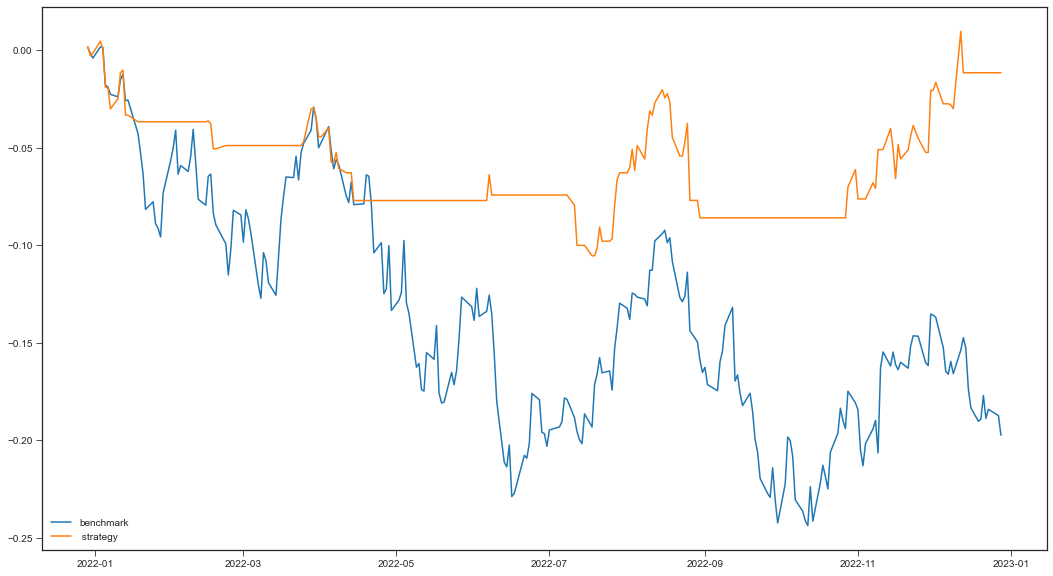

In [115]:
# Plot Equity Curves
fig = plt.figure(figsize = (18, 10))
plt.plot(df_main["bench_prod_exp"],label='benchmark')
plt.plot(df_main["strat_prod_exp"],label=' strategy')
plt.legend()
plt.show()

### Conclusion

It is clear that the moving average cross-over strategy performs vastly better in both returns and Sharpe Ratio, when trading only in favourable hidden states determined by the Hidden Markov Model unsupervised learning method. 